Chris's version

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
DS = xr.open_dataset('short')

In [2]:
#Temperature:
T = (DS.T.values + DS.T0) * ((DS.P.values + DS.PB.values)/DS.P0)**(DS.R_D/DS.CP)
albedo = DS.ALBEDO.values
st = DS.TSK.values
d_c = DS.TAU_OD.values
d_c2d = DS.TAU_OD2D.values
tsf = DS.TOASW.values #top solar flux
bsf = DS.GSW.values #bottom solar flux, ouput
e_in = [] #equator input
e_out = [] #equator output
e_t = [] #equator input and output

sl=slice(None,None,None)

In [3]:
for i in range(T.shape[0]):
    for j in range(T.shape[2]):
        input_array = list(T[i,:,sl,j]) #start with temp profile
        input_array+=list(d_c[i,:,sl,j]) #add dust profile
        input_array.append(albedo[i,sl,j])#add albedo
        input_array.append(st[i,sl,j])#add surface temp
        input_array.append(tsf[i,sl,j]) #add top solar flux
        e_in.append(input_array) #appends input to input array
        e_out.append(bsf[i,sl,j]) #appends output to output array
        total_array = input_array + [bsf[i,sl,j]] #adds input and output data together
        e_t.append(total_array) #appends everything to total array

In [24]:
e_t = [] #equator input and output
input_array=[]
sl=slice(0,52,None)
e_t = np.vstack(
                        [d_c2d[:,sl,:].reshape(-1),
                         #T[:,sl,:,:].transpose(0,2,3,1).reshape(-1,sl.stop-sl.start).T,
                         DS.PSFC.values[:,sl,:].reshape(-1),
                         tsf[:,sl,:].reshape(-1),
                         bsf[:,sl,:].reshape(-1)/(1-albedo[:,sl,:].reshape(-1)),
                        ]).T
e_t = e_t.reshape(d_c2d.shape[0],d_c2d.shape[1],d_c2d.shape[-1],-1)

In [25]:
e_t.shape

(240, 36, 72, 4)

In [22]:
e_t[10,:,:,-1].shape

(36, 72)

In [7]:
from sklearn.model_selection import train_test_split
e_tnZ = e_t.reshape(-1,e_t.shape[-1])
e_tnZ = e_tnZ[e_tnZ[:,-2]!=0,:]
e_d = pd.DataFrame(e_t.reshape(-1,e_t.shape[-1]))
train_set, test_set = train_test_split(e_d, test_size=0.2, random_state=42)

In [8]:
train_set.shape
train_in = train_set.iloc[:,:-1] #training input
train_out = train_set.iloc[:,-1] #training output
test_in = test_set.iloc[:,:-1] #training input
test_out = test_set.iloc[:,-1] #training output
indices = np.array(train_in.index)

#train_in

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(train_in, train_out)

train_pred = lin_reg.predict(train_in) #prediction
lin_mse = mean_squared_error(train_out, train_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

6.2994375

In [10]:
def plotdata(real, prediction,mask=False):
    plt.figure(figsize=(8,12))
    for sub,data,title in ([411,real,"Real"],
              [412,prediction,"Prediction"],
              [413,real-prediction,"Real-Prediction"],
              [414,(real-prediction)/real,"1-Prediction/Real"],
             ):
        plt.subplot(sub)
        md=np.ma.array(data,mask=mask)
        lev = np.percentile(md,np.arange(5,100,5))
        plt.pcolormesh(md)
        plt.colorbar()
        plt.title(title)
    
def reshape_and_predict(est, data):
    return est.predict(data.reshape(-1,data.shape[-1])).\
         reshape(data.shape[0],data.shape[1])
    


C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


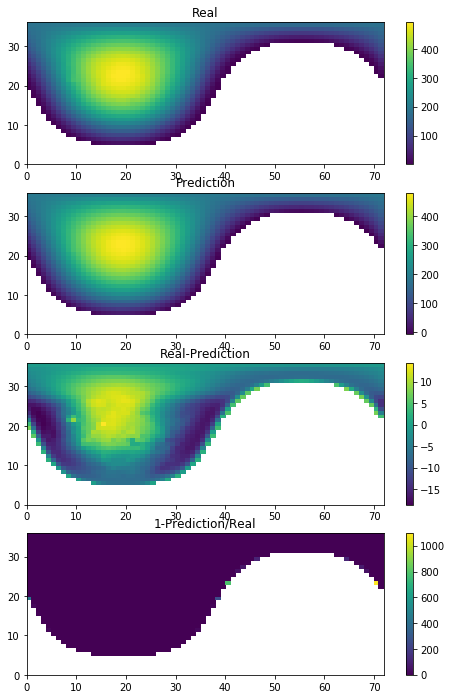

In [11]:
N=10    
plotdata(e_t[N,:,:,-1],
         reshape_and_predict(lin_reg,e_t[N,:,:,:-1]),
        mask=e_t[N,:,:,-2]==0)


C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


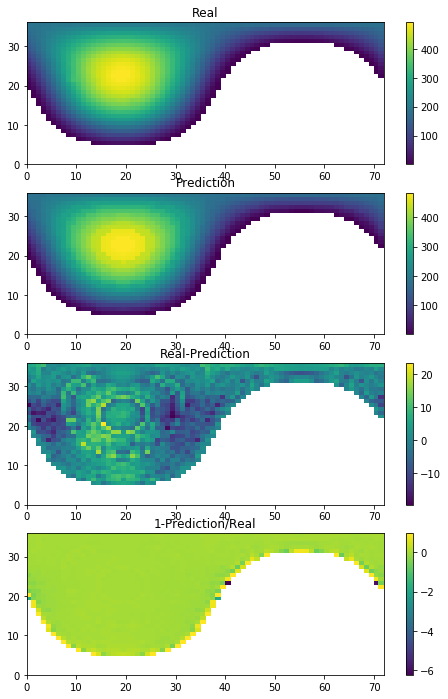

In [12]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=4, random_state=100, n_estimators=100)
skip = slice(0,-1,1000)
regr.fit(train_in[skip], train_out[skip].values.flatten())
N=10    
plotdata(e_t[N,:,:,-1],
         reshape_and_predict(regr,e_t[N,:,:,:-1]),
        mask=e_t[N,:,:,-2]==0)


In [13]:
rfr_pred = reshape_and_predict(regr,e_t[N,:,:,:-1])
rfr_out = e_t[N,:,:,-1]
rfr_mse = mean_squared_error(rfr_out, rfr_pred)
rfr_rmse = np.sqrt(rfr_mse)
rfr_rmse #better than linear regression error

4.473077061885275

In [14]:
rfr_rel = 1 - rfr_pred/rfr_out

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [15]:
np.max(rfr_rel) #nice

0.9831852055955679

In [26]:
len(rfr_rel[rfr_rel < -1]) - len(rfr_rel[rfr_rel < -1e100]) #42 extremely low values (but not negative infinity)

4

In [17]:
np.min(rfr_out[rfr_out != 0]) #least non negative real output

0.006550657

In [33]:
len(rfr_rel.flatten()) - len(rfr_rel[rfr_rel > -1]) #the vast majority of the realistic points have less than 100% relative error.

1278

In [35]:
len(rfr_rel[rfr_rel < -1e100]) #these have 0 bottom solar flux

1274

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


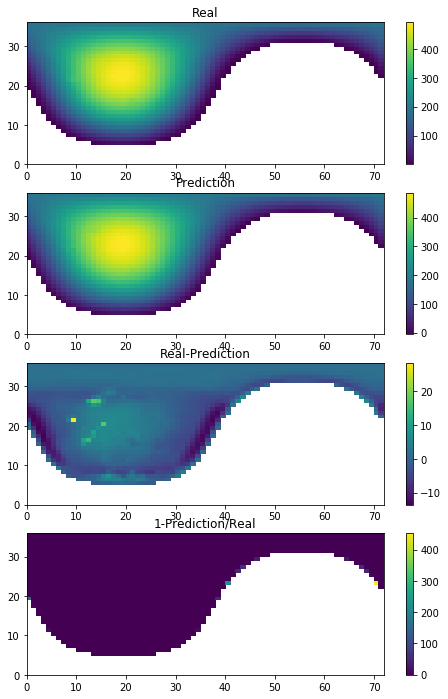

In [19]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor

est = make_pipeline(StandardScaler(), MLPRegressor(max_iter=2000))
est.fit(train_in[skip], train_out[skip])
N=10
plotdata(e_t[N,:,:,-1],
         reshape_and_predict(est,e_t[N,:,:,:-1]),
         mask=e_t[N,:,:,-2]==0)